In [3]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Extracting Sensory data

- We are using data from Garmin watch. 
- For this assignment running activities were observed, specifically tempo and recovery runs. 
- 4 runs were extracted: 12km tempo, 10km tempo, 10km recovery, 8km recovery. In total, ~4h of data. Each run activity is labeled according to its type and distance.
- **Features:** 
    - Time
    - Distance
    - Altitude
    - Cadence
    - HeartRate
    - Speed
- **Engineered features (TBD):**
    - Pace (Time/Distance)
    - Elevation Gain (to be calculated)
    - Cadence per minute (In current dataset cadence metric is really akward and hardly understandable. Usually, cadence measures frequency of steps (for both feet) per minute. Moreover, in this dataset cadence corresponds to frequency of steps only for one foot, so it should be multiplied by 2)

In [4]:
def parse_tcx(tcx_file):
    tree = ET.parse(tcx_file)
    root = tree.getroot()

    data = []
    
    for activity in root.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities'):
        for lap in activity.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Lap'):
            for track in lap.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Track'):
                for trackpoint in track.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Trackpoint'):
                    # Extract time, distance, and heart rate data
                    time_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time')
                    distance_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters')
                    heart_rate_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}HeartRateBpm/{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Value')
                    speed_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Extensions/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}TPX/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}Speed')
                    run_cadence_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Extensions/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}TPX/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}RunCadence')
                    altitude_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}AltitudeMeters')
                    
                    if time_element is not None and distance_element is not None and heart_rate_element is not None and run_cadence_element is not None and speed_element is not None:
                        data.append({
                            'Time': time_element.text,
                            'Distance': float(distance_element.text),
                            'Altitude': float(altitude_element.text),
                            'HeartRate': int(heart_rate_element.text),
                            'Speed': float(speed_element.text),
                            'Cadence': int(run_cadence_element.text)
                        })

    return data

def heart_rate_zone(heart_rate):
    # Define your own heart rate zones here
    if heart_rate < 120:
        return 'Zone 1'
    elif heart_rate < 140:
        return 'Zone 2'
    elif heart_rate < 160:
        return 'Zone 3'
    elif heart_rate < 180:
        return 'Zone 4'
    else:
        return 'Zone 5'


# Calculate pace (time per km) - note this is a simple calculation and may not be accurate
def calculate_pace(df):
    df['Time'] = pd.to_datetime(df['Time'])
    timeDiff = df['Time'].diff()
    distanceDiff = df['Distance'].diff()
    df['Pace'] = timeDiff.dt.total_seconds() / distanceDiff
    

#Activity labels. Currently not used
labels = ['recovery','tempo']

In [5]:
tcx_files = ['10km_tempo.tcx', '12km_tempo.tcx', '8km_recovery.tcx', '10km_recovery.tcx']

dataframes = []

for file in tcx_files:
    # Parse the TCX file to a DataFrame
    data = parse_tcx('data/'+ file)
    df = pd.DataFrame(data)
    calculate_pace(df)
    df['HeartRateZone'] = df['HeartRate'].apply(heart_rate_zone)
    df['Run'] = os.path.splitext('data/'+ file)[0]  # extracts "10km_tempo", "12km_tempo", etc. from file names

    # Append the DataFrame to the list
    dataframes.append(df)
# Concatenate all dataframes
all_runs_df = pd.concat(dataframes, ignore_index=True)
all_runs_df.to_csv('running_data.csv')

In [ ]:
#hello! hellooo!

In [ ]:
#hello helooo from nina

In [6]:
data = pd.read_csv('running_data.csv', delimiter = ',')

print(data)

       Unnamed: 0                       Time      Distance    Altitude  \
0               0  2022-07-29 05:21:40+00:00      1.200000  325.600006   
1               1  2022-07-29 05:21:41+00:00      3.670000  325.600006   
2               2  2022-07-29 05:21:42+00:00      6.070000  325.600006   
3               3  2022-07-29 05:21:43+00:00      7.870000  325.600006   
4               4  2022-07-29 05:21:44+00:00     10.080000  325.600006   
...           ...                        ...           ...         ...   
15113       15113  2022-09-06 06:00:59+00:00  10003.740234   -1.000000   
15114       15114  2022-09-06 06:00:59+00:00  10003.740234   -1.000000   
15115       15115  2022-09-06 06:01:00+00:00  10006.309570   -0.800000   
15116       15116  2022-09-06 06:01:01+00:00  10010.650391   -0.800000   
15117       15117  2022-09-06 06:01:02+00:00  10010.650391   -0.800000   

       HeartRate  Speed  Cadence      Pace HeartRateZone                 Run  
0             92  0.000       83

In [7]:
# subsets per different run 

grouped_df = data.groupby('Run')

# Create a dictionary of DataFrames, where each DataFrame corresponds to a unique value in 'Category'
dataframes = {group: frame for group, frame in grouped_df}

# Access individual DataFrames
df_A = dataframes['data/10km_tempo']
df_B = dataframes['data/10km_recovery']
# df_C = dataframes['C']

# print(df_A)

unique_values = data['Run'].unique()
unique_values


array(['data/10km_tempo', 'data/12km_tempo', 'data/8km_recovery',
       'data/10km_recovery'], dtype=object)

In [9]:
subset = data[12500:12600]  


def count_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing values per column:")
    for column, count in missing_values.iteritems():
        print(f"{column}: {count}")

# Example usage:
df = pd.DataFrame({
    'A': [1, 2, None, 4],
    'B': [5, None, 7, 8],
    'C': [9, 10, 11, None]
})

count_missing_values(data)

Missing values per column:
Unnamed: 0: 0
Time: 0
Distance: 0
Altitude: 0
HeartRate: 0
Speed: 0
Cadence: 0
Pace: 44
HeartRateZone: 0
Run: 0


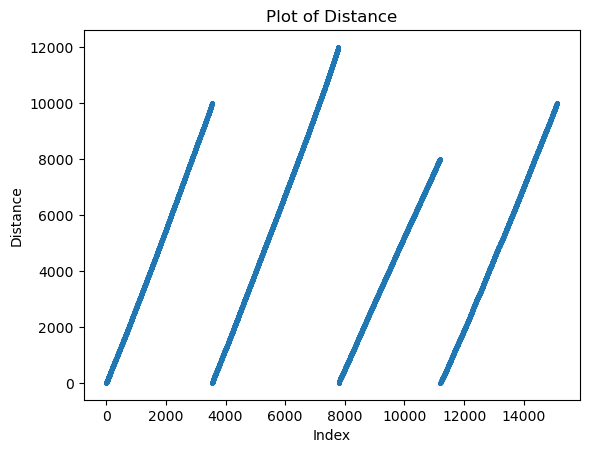

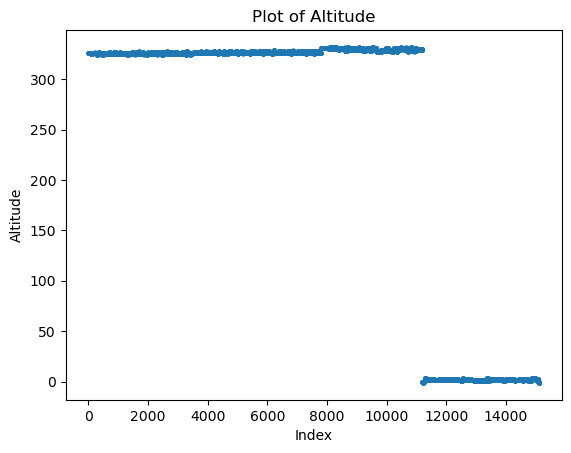

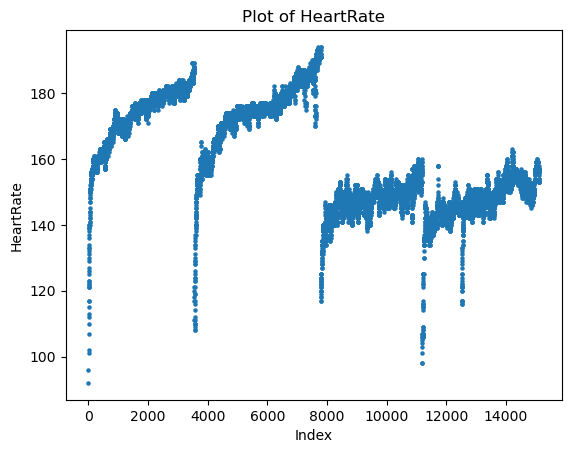

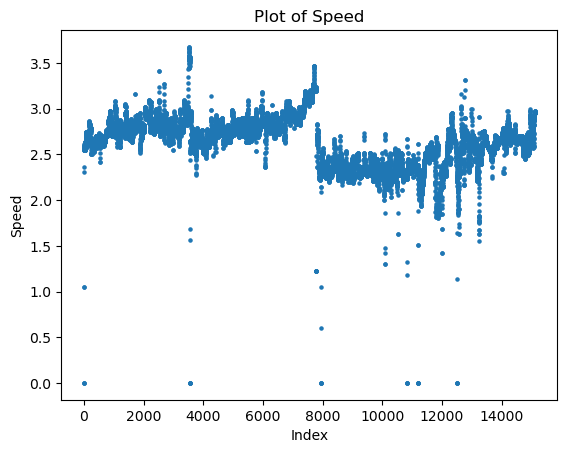

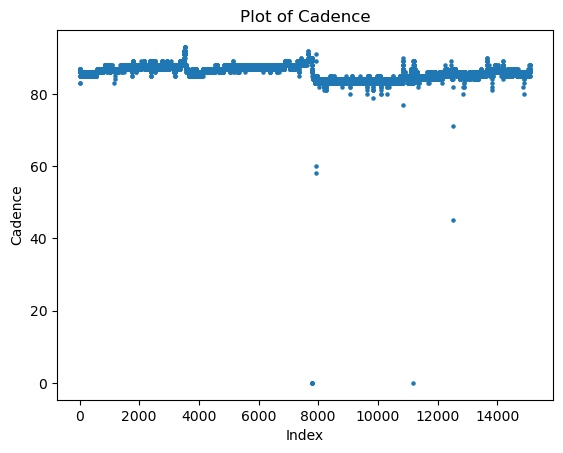

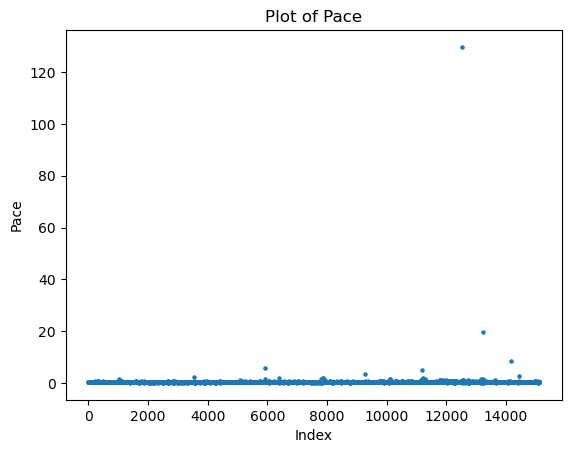

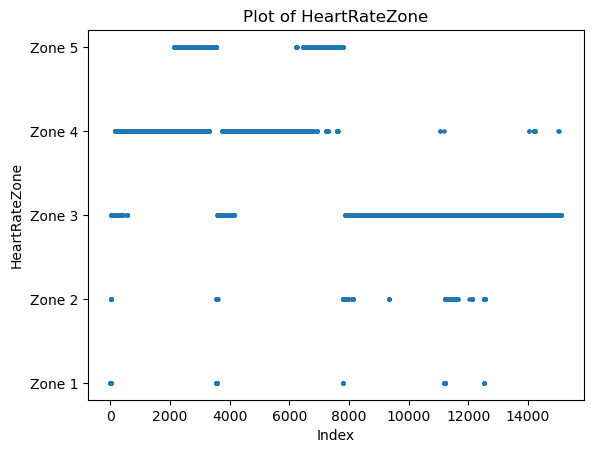

In [11]:
def plot_column(df, column_name):
    # plt.plot(df[column_name])
    plt.scatter(df.index, df[column_name], marker='o', s=5)
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.title(f'Plot of {column_name}')
    plt.show()


plot_column(data, 'Distance')
plot_column(data, 'Altitude')
plot_column(data, 'HeartRate')
plot_column(data, 'Speed')
plot_column(data, 'Cadence')
plot_column(data, 'Pace')
plot_column(data, 'HeartRateZone')


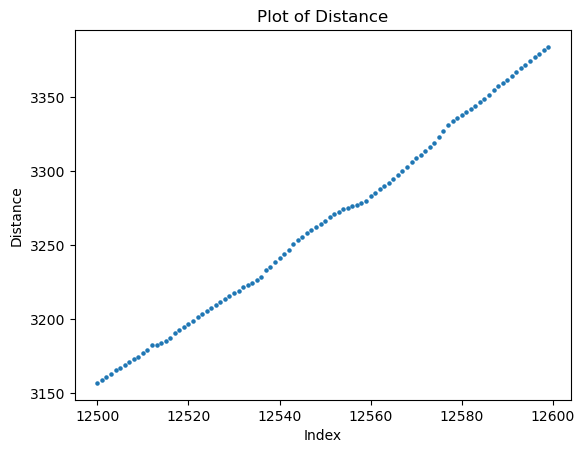

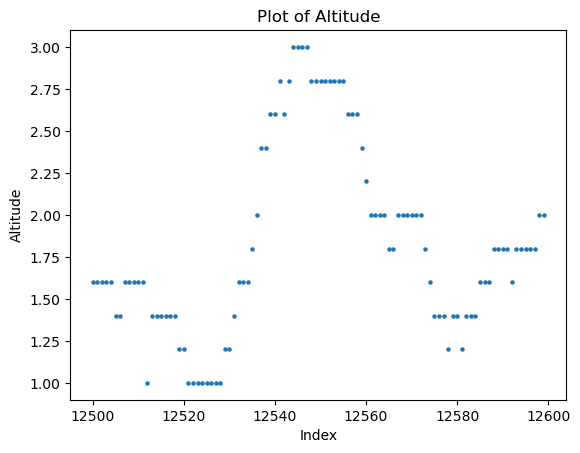

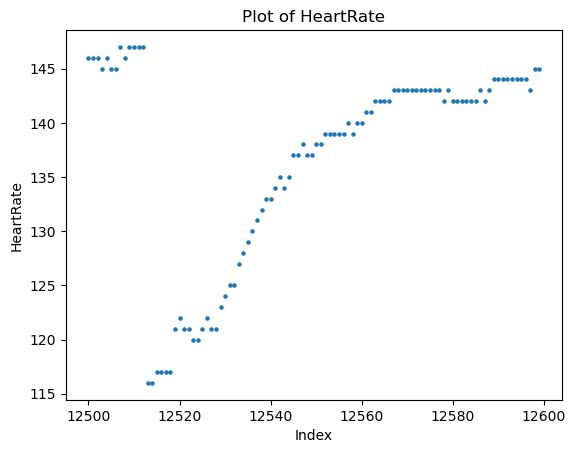

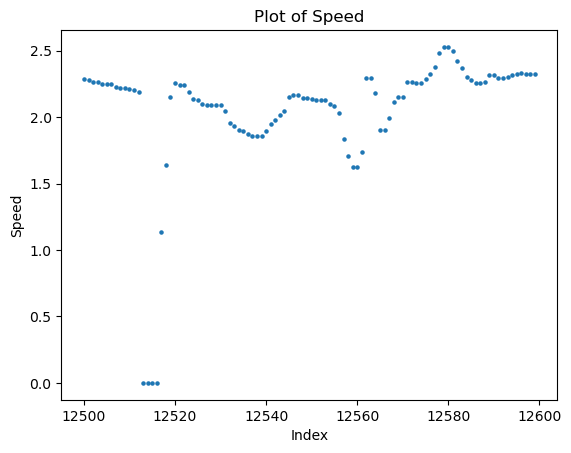

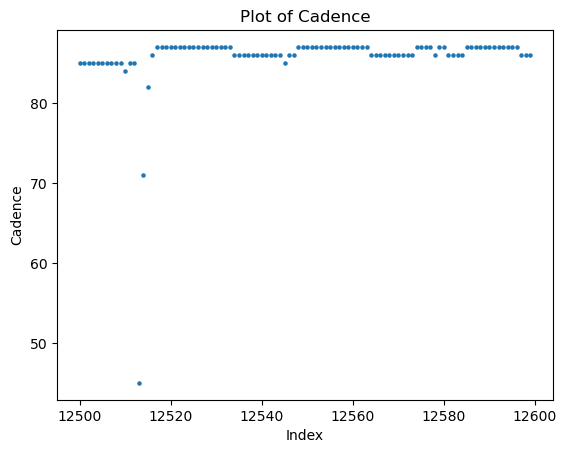

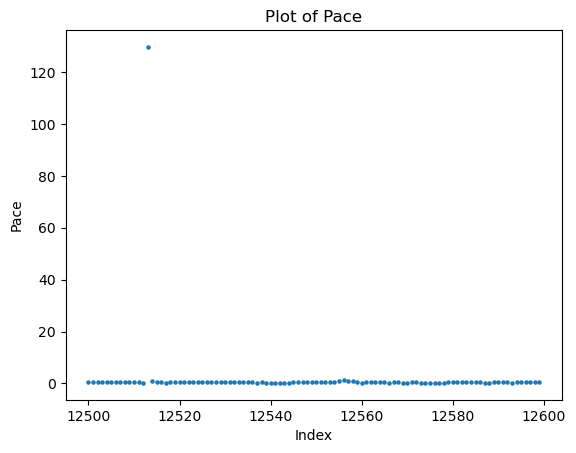

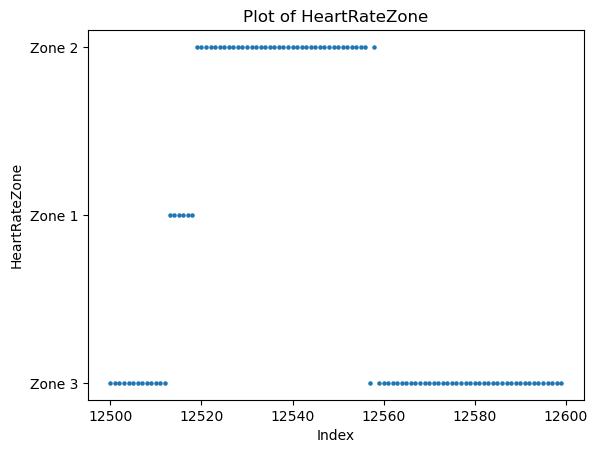

In [12]:
# column_name = 'Pace'
plot_column(subset, 'Distance')
plot_column(subset, 'Altitude')
plot_column(subset, 'HeartRate')
plot_column(subset, 'Speed')
plot_column(subset, 'Cadence')
plot_column(subset, 'Pace')
plot_column(subset, 'HeartRateZone')


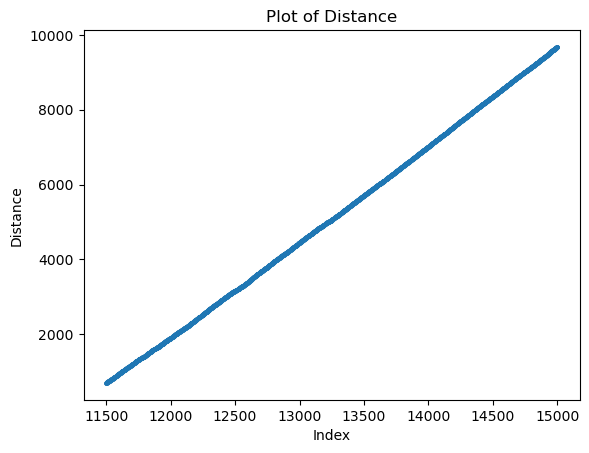

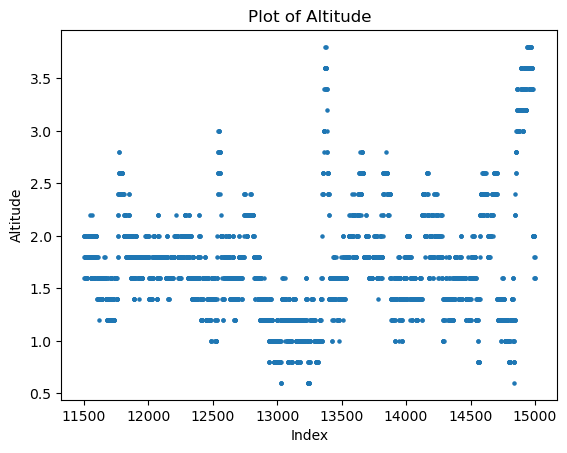

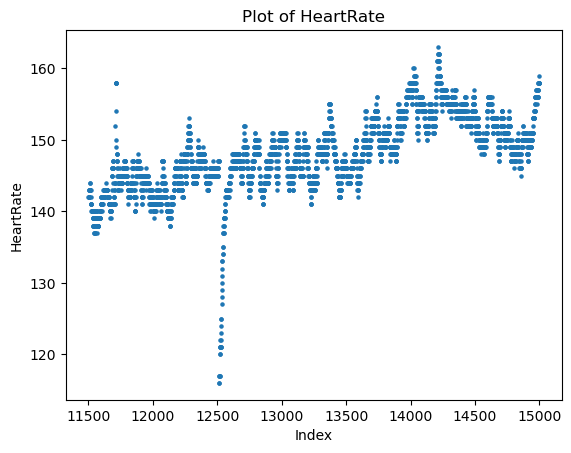

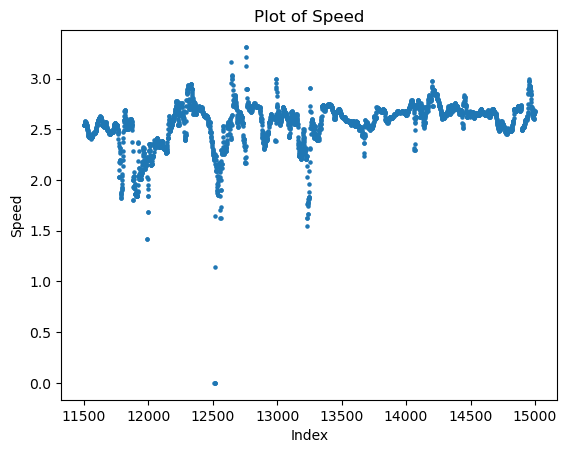

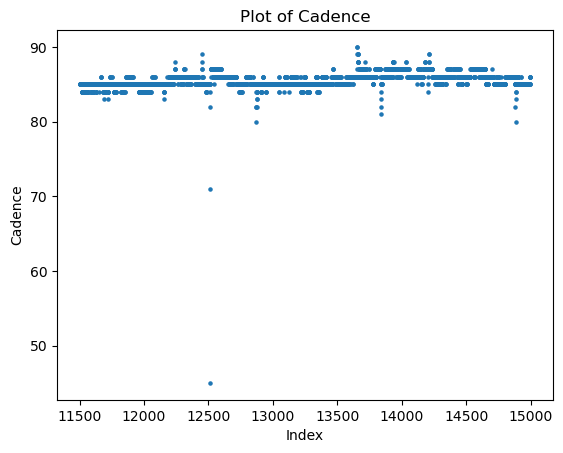

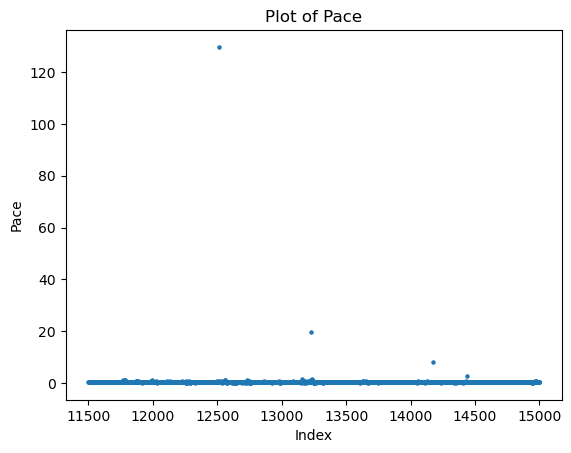

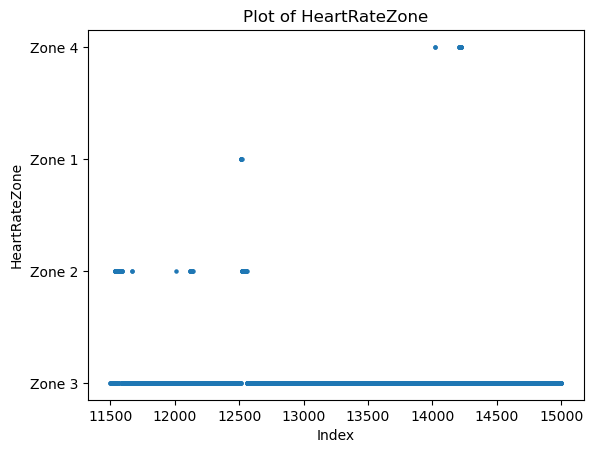

In [13]:
subset2 = data[11500:15000]

# column_name = 'Pace'
plot_column(subset2, 'Distance')
plot_column(subset2, 'Altitude')
plot_column(subset2, 'HeartRate')
plot_column(subset2, 'Speed')
plot_column(subset2, 'Cadence')
plot_column(subset2, 'Pace')
plot_column(subset2, 'HeartRateZone')